In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Input, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU
from keras.layers.merge import dot, concatenate
from keras.optimizers import Adam
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries, get_task2
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 128
BATCH_SIZE = 1024

# Data

In [20]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset['active_power_original'] = dataset['active_power']
dataset['active_power'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_cos'] = np.cos(dataset['active_power'])
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset['active_power5'] = dataset['active_power']**5

dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.94)

# train_y = pad_sequences(train_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# test_y = pad_sequences(test_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# train_y = pad_sequences(train_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)
# test_y = pad_sequences(test_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-30 01:51:11,317 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 13:51:00,0.531333,0.082,246.37,2.2,0.0,0.0,1.0,0,0,0
2010-10-27 13:52:00,0.525167,0.082,246.69,2.2,0.0,0.0,0.0,0,0,0
2010-10-27 13:53:00,0.522333,0.070,246.98,2.4,0.0,0.0,1.0,0,0,0
2010-10-27 13:54:00,0.530667,0.062,247.19,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 13:55:00,0.538833,0.062,246.70,2.6,0.0,0.0,0.0,0,0,0


data_x: (43503, 38)
data_y: (43503, 1)

diff_x: (43503, 1)
diff_y: (43503, 1)

train_x: (39460, 128, 38)
train_y: (39460, 128, 1)

test_x: (2519, 128, 38)
test_y: (2519, 128, 1)


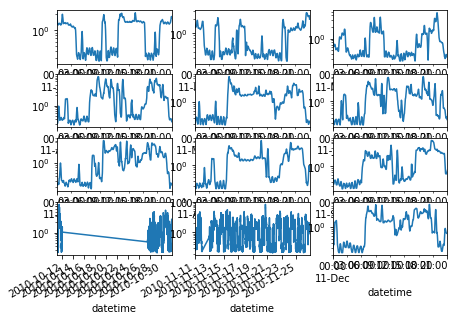

In [22]:
def show_active_power():
    fig, plots = subplots(4, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    for i, p in enumerate(plots):
        i += 1
        dataset['active_power'].loc[f'2010-{i:02}'].plot(logy=True, ax=p)
        
show_active_power()

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


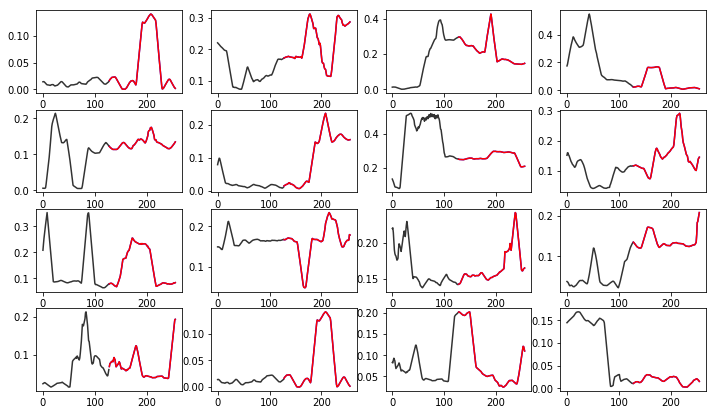

In [7]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n-SEQUENCE_SIZE)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')
        
print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

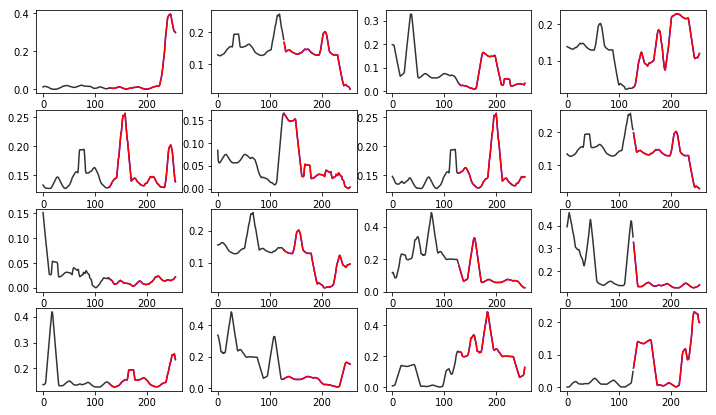

In [21]:
vis_dataset(test_x, test_y)

# Models

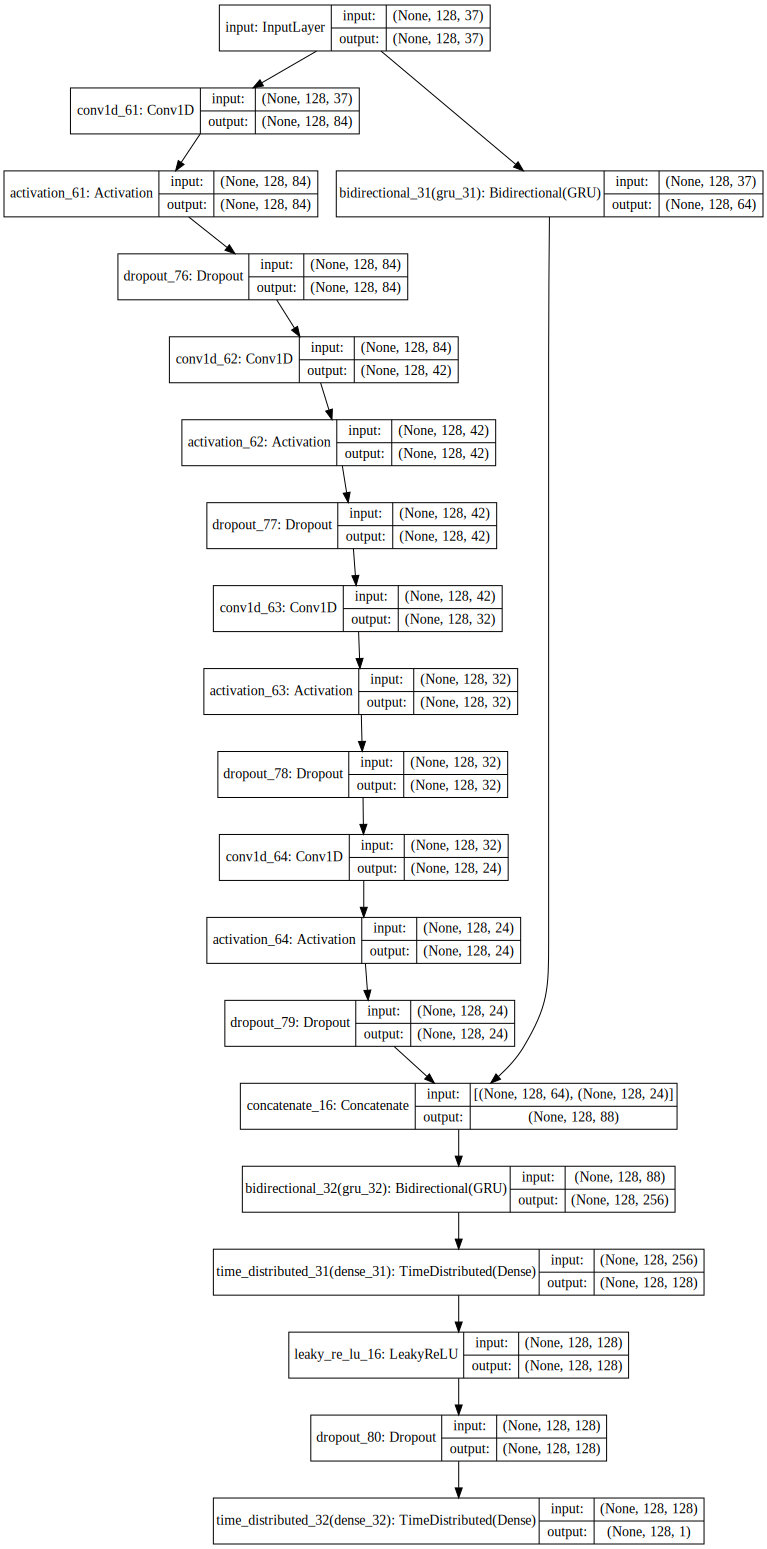

In [29]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1, l2, d1=64, dout1=None, n_input=40):
    np.random.seed(0)
    input = Input(shape=(SEQUENCE_SIZE, n_input), name='input')
    rnn1 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.25))(input)
    
    cnn = Conv1D(filters=84, kernel_size=4, padding='same')(input)
#     cnn = AvgPool1D(2, strides=1, padding='same')(cnn)
    cnn = Activation('relu')(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = Conv1D(filters=42, kernel_size=3, padding='same')(cnn)
#     cnn = AvgPool1D(2, strides=1, padding='same')(cnn)
    cnn = Activation('relu')(cnn)
    cnn = Dropout(0.2)(cnn)
    cnn = Conv1D(filters=32, kernel_size=3, padding='same')(cnn)
#     cnn = AvgPool1D(2, strides=1, padding='same')(cnn)
    cnn = Activation('relu')(cnn)
    cnn = Dropout(0.1)(cnn)
    cnn = Conv1D(filters=24, kernel_size=2, padding='same')(cnn)
#     cnn = AvgPool1D(2, strides=1, padding='same')(cnn)
    cnn = Activation('relu')(cnn)
    cnn = Dropout(0.1)(cnn)
    
    concat = concatenate([rnn1, cnn], axis=-1)
    rnn3 = Bidirectional(GRU(l2, return_sequences=True, recurrent_dropout=0.1))(concat)
    
    h1 = TimeDistributed(Dense(d1))(rnn3)
    h1 = LeakyReLU()(h1)
    if dout1:
        h1 = Dropout(dout1)(h1)
    h1 = TimeDistributed(Dense(1))(h1)
    
    model = Model(inputs=[input], outputs=[h1])
    model.compile(optimizer=Adam(clipnorm=1.), 
                  loss='mse',
                  metrics=[r2])
    return model

model = create_model(32, 128, d1=128, dout1=0.3, n_input=37)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [30]:
BATCH_SIZE = 1024
model = create_model(64, 128, d1=128, dout1=0.3, n_input=38)
history = History()
model.fit(train_x, train_y, epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 39460 samples, validate on 2519 samples
Epoch 1/200
34s - loss: 0.0165 - r2: -2.3549e-01 - val_loss: 0.0060 - val_r2: 0.2644
Epoch 2/200
31s - loss: 0.0104 - r2: 0.2224 - val_loss: 0.0058 - val_r2: 0.2732
Epoch 3/200
31s - loss: 0.0096 - r2: 0.2766 - val_loss: 0.0058 - val_r2: 0.2619
Epoch 4/200
32s - loss: 0.0091 - r2: 0.3190 - val_loss: 0.0057 - val_r2: 0.2773
Epoch 5/200
31s - loss: 0.0084 - r2: 0.3712 - val_loss: 0.0055 - val_r2: 0.2734
Epoch 6/200
31s - loss: 0.0073 - r2: 0.4497 - val_loss: 0.0052 - val_r2: 0.3095
Epoch 7/200
31s - loss: 0.0065 - r2: 0.5147 - val_loss: 0.0053 - val_r2: 0.3140
Epoch 8/200
31s - loss: 0.0057 - r2: 0.5747 - val_loss: 0.0054 - val_r2: 0.2661
Epoch 9/200
31s - loss: 0.0052 - r2: 0.6124 - val_loss: 0.0052 - val_r2: 0.2995
Epoch 10/200
31s - loss: 0.0049 - r2: 0.6350 - val_loss: 0.0049 - val_r2: 0.3417
Epoch 11/200
31s - loss: 0.0044 - r2: 0.6667 - val_loss: 0.0047 - val_r2: 0.3452
Epoch 12/200
31s - loss: 0.0041 - r2: 0.6888 - val_loss: 0.0053 

KeyboardInterrupt: 

# Evaluation

In [10]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 780 ms, sys: 96 ms, total: 876 ms
Wall time: 761 ms
loss: 0.005554864249611121
r2: 0.3871971051868281


[36479] r^2: -17.89      
[16607] r^2: -0.3098     
[18921] r^2: -4.533      
[38907] r^2: 0.8698      
[10411] r^2: -0.1418     
[21250] r^2: 0.4943      
[32682] r^2: 0.1599      
[26367] r^2: 0.4295      
[15536] r^2: -0.4816     
[1666] r^2: -0.3944     
[3074] r^2: -0.4551     
[37860] r^2: -0.7782     
[3464] r^2: 0.7859      
[33751] r^2: 0.04451     
[8367] r^2: -0.9274     
[9485] r^2: 0.6281      


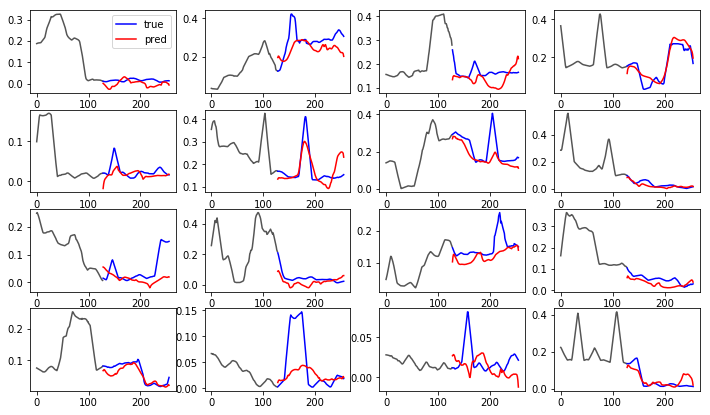

In [32]:
def vis_evaluate(model, test_x, test_y, batch=32):
    n = len(test_x)
    seq_n = test_x.shape[1]

    fig, plots = pylab.subplots(4, 4)
    plots = plots.reshape(-1)

    fig.set_figwidth(12)
    fig.set_figheight(7)

    for i, p in enumerate(plots):
        idx = np.random.randint(0, n)
        input_y = test_x[idx, :, 0]
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n * 2)

        true_y = test_y[idx]
        pred1 = model.predict(test_x[idx:idx + 1], batch_size=batch)

        score = r2_score(true_y.reshape(-1), pred1.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')
        p.plot(x1, input_y, color='#555555')
        p.plot(x2, true_y, color='blue', label='true')
        p.plot(x2, pred1[0], color='red', label='pred')
        if i == 0:
            p.legend()


vis_evaluate(model, train_x, train_y, batch=BATCH_SIZE)